In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [71]:
def load_pkl(fname):
  with open(fname, 'rb') as file:
    data = pickle.load(file)
  return data

In [72]:
def get_X_Y(data):
  return data['X'],data['Y']

def get_X(data):
  return data['X']


In [73]:
def reshape_data(data):
    data = np.array([single.reshape(784) for single in data])  # reshape from (28,28,N) to (784 ,N)  # prompt-5
    return data

In [74]:
def print_image(data):
    plt.imshow(data, cmap='gray'); 
    plt.show()

In [75]:
def print_unique_images(X,Y):
    labels = np.unique(Y)
    print(f"The labels in the data: {labels}")
    
    labels_counter = []
    
    for i in range(len(X)):                         # convert the number to letters
        if Y[i] not in labels_counter:
            print(f"Label: {chr(ord('a') + Y[i])}") # prompt-2
            print_image(X[i])
            labels_counter.append(Y[i])
        if len(labels_counter) == len(labels):
                break

In [76]:
def print_unique_labels(Y):
    print(f"The labels in this data: {np.unique(Y)}")

In [77]:
def to_numpy_float(data):
    data = np.array(data)
    data = data.astype(float)
    return data

train data original shape: (28, 28, 27455)
The labels in this data: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
The labels in the data: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label: d


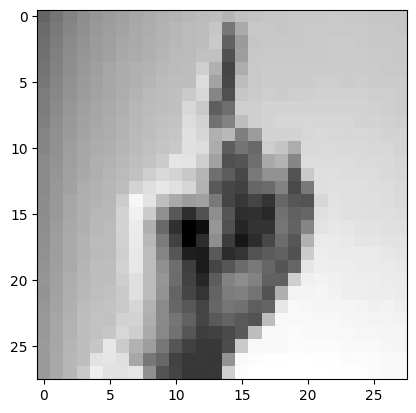

Label: g


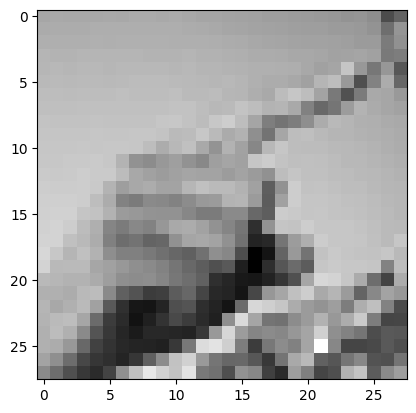

Label: c


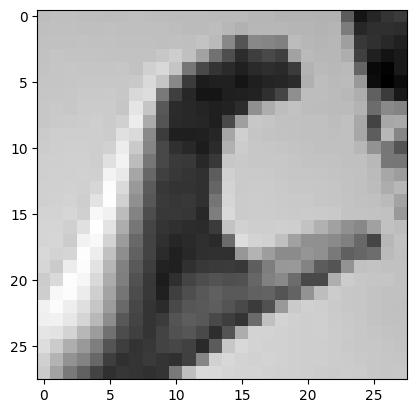

Label: n


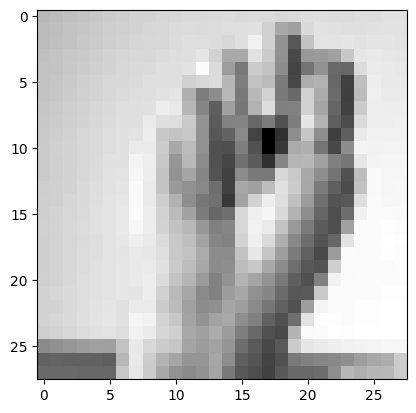

Label: q


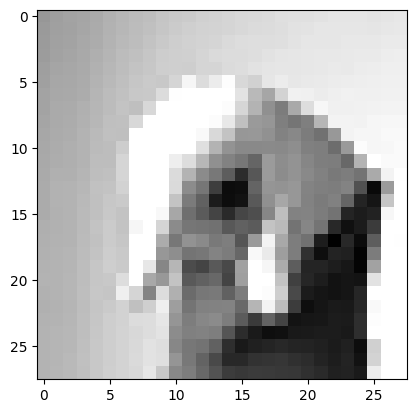

Label: i


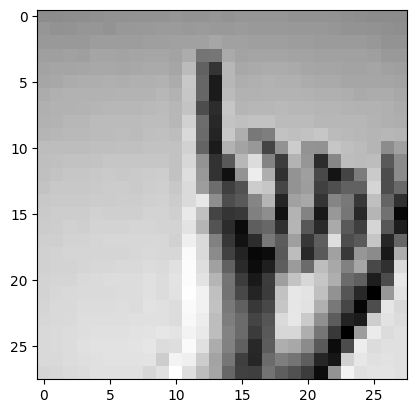

Label: w


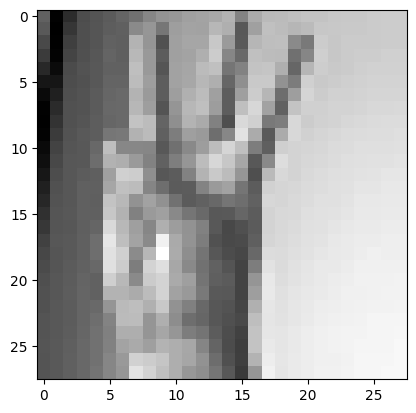

Label: s


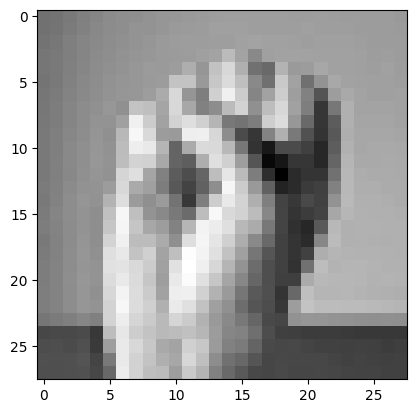

Label: k


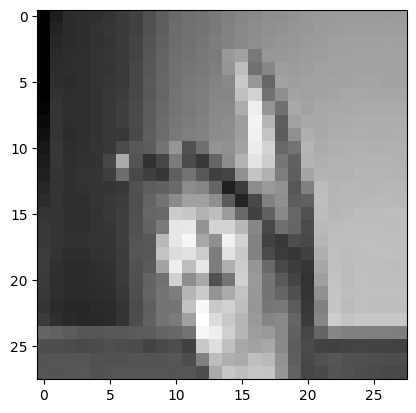

Label: u


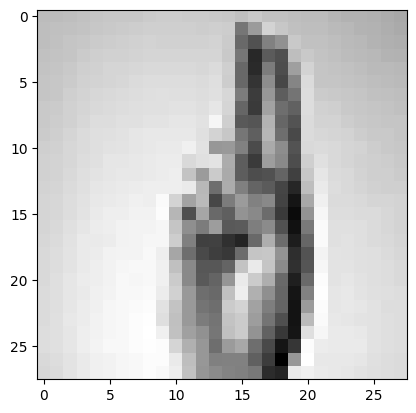

Label: r


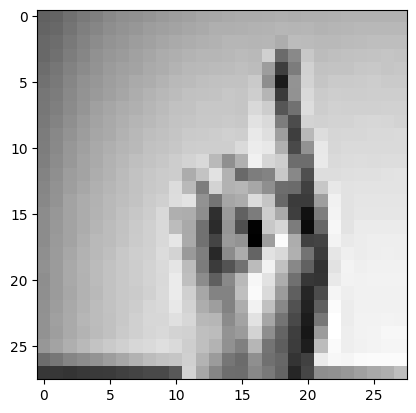

Label: t


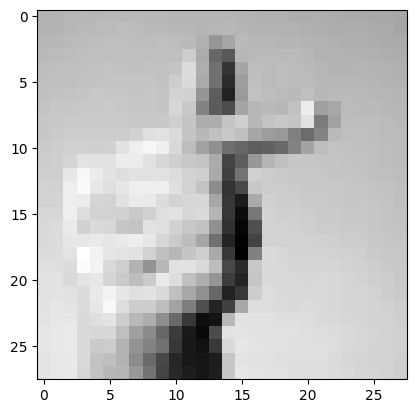

Label: v


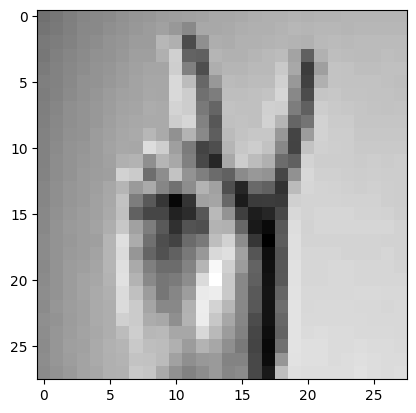

Label: x


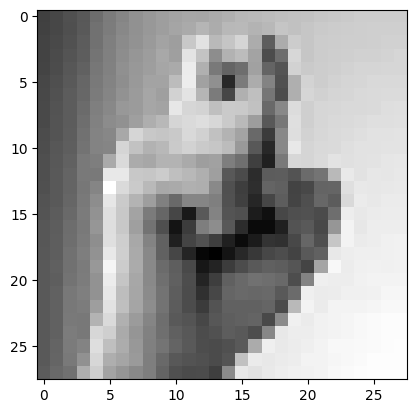

Label: y


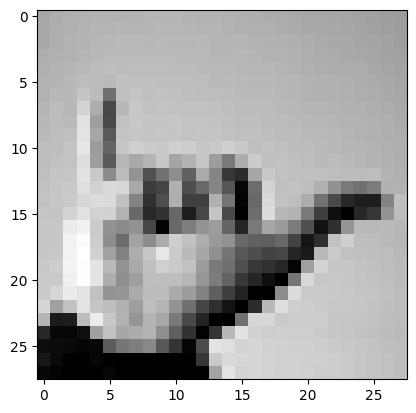

Label: b


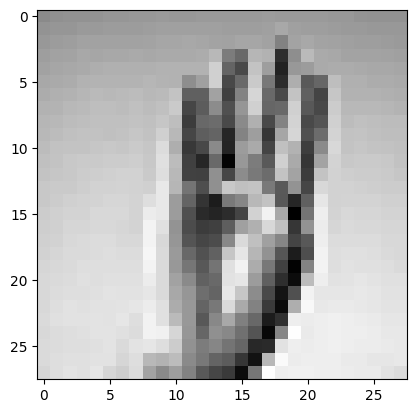

Label: m


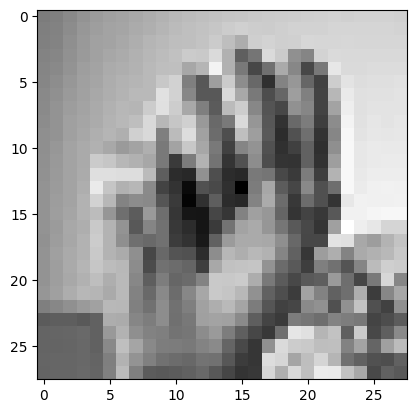

Label: l


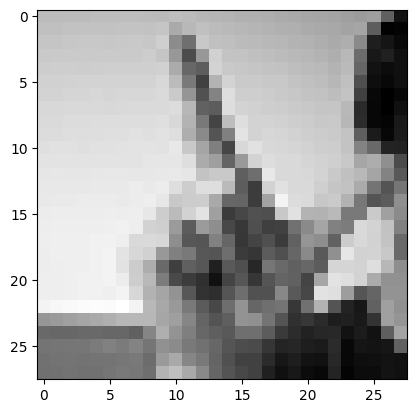

Label: p


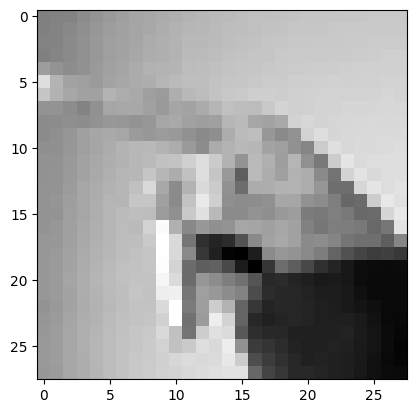

Label: e


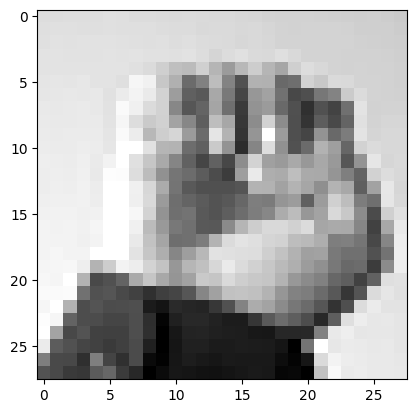

Label: a


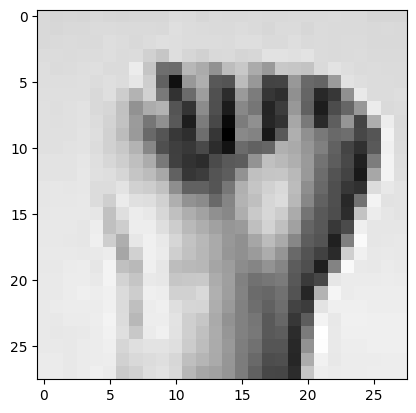

Label: f


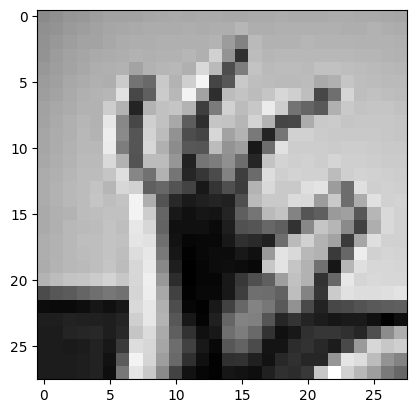

Label: h


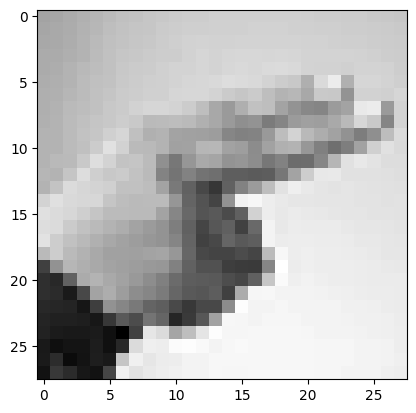

Label: o


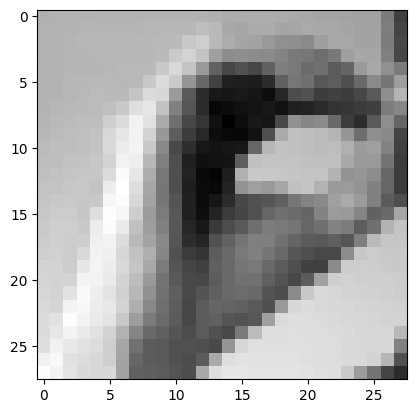

In [78]:
# 1 - A
TrainData = load_pkl("TrainData.pkl")
X_train , Y_train = get_X_Y(TrainData)
print(f"train data original shape: {X_train.shape}")

# 1 - B
train_images = np.moveaxis(X_train, -1 , 0) # prompt-1 - arranging the shape of the array
train_images = to_numpy_float(train_images)
print_unique_labels(Y_train)
print_unique_images(train_images, Y_train)


In [79]:
# 1 - C
reshaped_X_train = reshape_data(train_images)

print(f"X_train after reshaped: {reshaped_X_train.shape}")

X_train after reshaped: (27455, 784)


In [80]:
# 3 - A 

def find_QDA_params(X, Y):          # from class notebook we calclate the parms of mu_ml pi_ml and sigma_ml
    labels = np.unique(Y)
    mu_ml = []
    pi_ml = []
    sigma_ml = []
    
    for label in labels:
        sigma = 0
        current_X = X[Y == label]
        this_mu_ml = np.mean(current_X, axis=0)
        mu_ml.append(this_mu_ml)
        this_mu_ml = np.array([this_mu_ml])
        pi_ml.append((Y == label).mean())
        count = np.sum(Y == label)

        for row in current_X:
            row = np.array([row])
            single_sigma = row.T @ row
            sigma = sigma + single_sigma
        
        sigma = sigma * (1 / (count-1)) - np.dot(this_mu_ml.T, this_mu_ml)
        sigma_ml.append(sigma)

    return labels, mu_ml, pi_ml, sigma_ml

In [81]:
print(f"reshaped_X_train size: {reshaped_X_train.shape}")
labels, mu_ml, pi_ml, sigma_ml = find_QDA_params(reshaped_X_train , Y_train)
print(f"shapes of Θ:\npi_ml: {np.array(pi_ml).shape} \nmu_ml: {np.array(mu_ml).shape} \nsigma_ml: {np.array(sigma_ml).shape}")

reshaped_X_train size: (27455, 784)
shapes of Θ:
pi_ml: (24,) 
mu_ml: (24, 784) 
sigma_ml: (24, 784, 784)


In [82]:
def gussians(x, mu_ml, sigma_ml_det, sigma_ml_inv):
    mu_ml_numpy = np.array(mu_ml)
    x_numpy = np.array(x)

    ans = (-0.5) * (np.sum(np.log(sigma_ml_det))) - (0.5) * (((x_numpy-mu_ml_numpy).T) @ sigma_ml_inv) @ (x_numpy-mu_ml_numpy) # Arik showed in class
    
    return ans

In [83]:
# 2 - 𝑦̂(𝑥) = ...

def custom_QDA_classification(x_examples , labels , mu_ml , pi_ml, sigma_ml_det_array, sigma_ml_inv_array):
    y_pred_array = []

    for single_example in x_examples:
        gussians_array = {}

        for i in range(len(labels)):
            gussians_array[i]= gussians(single_example, mu_ml[i], sigma_ml_det_array[i], sigma_ml_inv_array[i]) + np.log(pi_ml[i])

        max_key = max(gussians_array, key=gussians_array.get) # get the max index from the array
        y_pred_array.append(max_key)

    return y_pred_array


In [84]:

def custom_QDA_accuracy(Y_true,y_pred):
    return np.mean(Y_true == y_pred) * 100

In [85]:
def plot_estimated_mean_vectors(mu_ml,labels):
    
    ignore_9 = 0 
    for i in range(len(mu_ml)):
        this_mu_reshaped = np.reshape(mu_ml[i], (28, 28))
        print(f"Label: {chr(ord('a') + labels[i])}")
        plt.imshow(this_mu_reshaped, cmap='gray')
        plt.show()


In [86]:

# 3 - B

x_examples = reshaped_X_train
print(f"x_examples.shape: {x_examples.shape}")
print(f"the original labels are: {Y_train}")

sigma_ml_inv_array = []
sigma_ml_det_array = []
for i in range(len(labels)):
    sigma_ml_numpy = np.array(sigma_ml[i])
    
    sigma_ml_inv = np.linalg.inv(sigma_ml_numpy)            # Arik showed in class
    sigma_ml_det , matrix_tmp = np.linalg.eig(sigma_ml[i])  # Arik showed in class

    sigma_ml_inv_array.append(sigma_ml_inv)
    sigma_ml_det_array.append(sigma_ml_det)

# use our classification functions we create before to find the prediction
y_pred_array = custom_QDA_classification(x_examples,labels , mu_ml , pi_ml ,sigma_ml_det_array, sigma_ml_inv_array)  
print(f"the y_pred labels are: {y_pred_array}")


#The label in the train data: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]

x_examples.shape: (27455, 784)
the original labels are: [ 3  6  2 ... 18 17 23]
the y_pred labels are: [3, 6, 2, 2, 12, 15, 8, 21, 3, 3, 17, 9, 15, 21, 19, 15, 16, 12, 12, 18, 17, 20, 15, 22, 3, 22, 23, 17, 21, 1, 1, 11, 2, 6, 2, 11, 22, 2, 3, 12, 10, 14, 19, 2, 4, 9, 0, 18, 5, 7, 0, 10, 6, 20, 17, 18, 20, 7, 0, 0, 4, 13, 14, 9, 5, 18, 2, 12, 7, 15, 11, 8, 14, 10, 20, 13, 9, 6, 17, 10, 15, 13, 15, 17, 4, 2, 15, 13, 22, 0, 20, 15, 9, 13, 16, 1, 14, 17, 4, 15, 11, 18, 17, 11, 17, 9, 1, 5, 20, 17, 9, 9, 21, 4, 18, 10, 11, 1, 9, 5, 19, 0, 19, 10, 22, 13, 0, 22, 9, 7, 23, 5, 14, 19, 19, 18, 6, 19, 18, 3, 23, 4, 11, 9, 8, 8, 6, 20, 12, 2, 19, 1, 18, 13, 18, 17, 10, 16, 19, 20, 3, 4, 22, 7, 23, 15, 20, 19, 22, 8, 4, 21, 7, 1, 18, 14, 14, 4, 13, 13, 22, 2, 10, 17, 1, 8, 3, 5, 10, 13, 17, 13, 5, 5, 21, 9, 2, 12, 3, 15, 21, 17, 6, 15, 18, 21, 18, 6, 20, 19, 12, 16, 9, 23, 22, 14, 17, 14, 3, 3, 0, 0, 1, 7, 20, 18, 18, 2, 9, 19, 18, 13, 8, 10, 13, 16, 22, 16, 10, 23, 14, 17, 17, 3, 12, 0, 2, 21, 1

Label: a


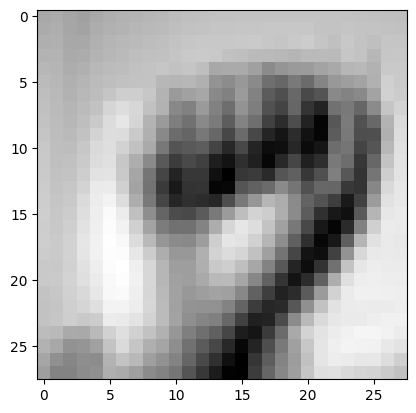

Label: b


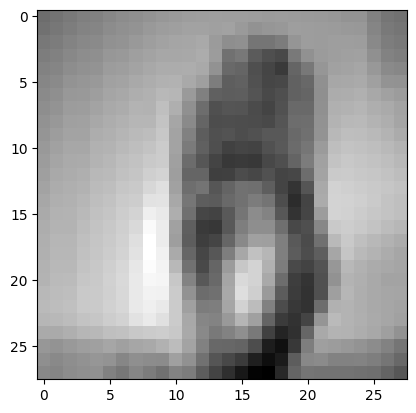

Label: c


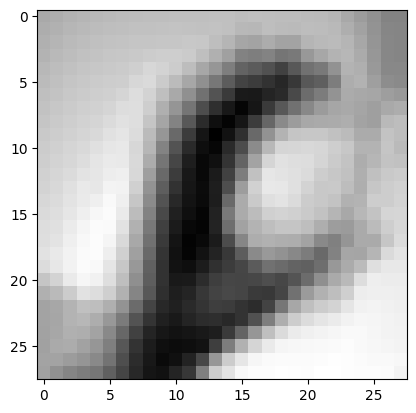

Label: d


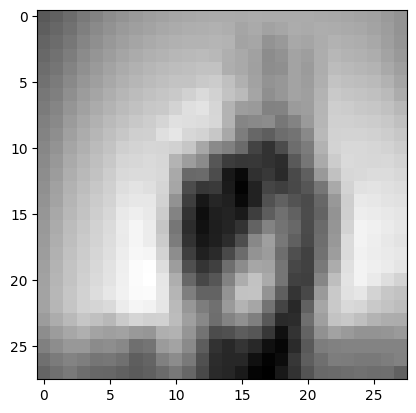

Label: e


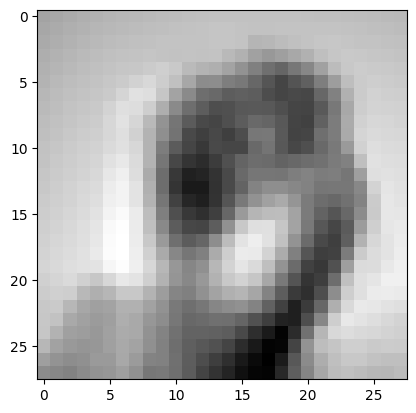

Label: f


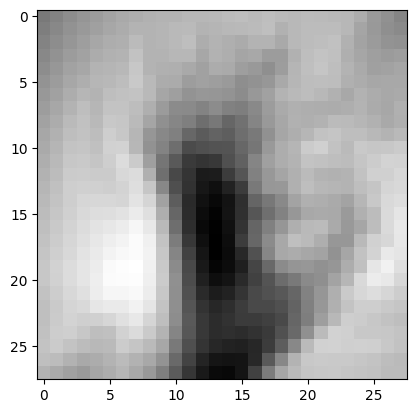

Label: g


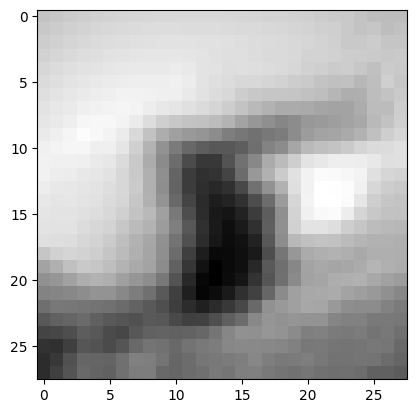

Label: h


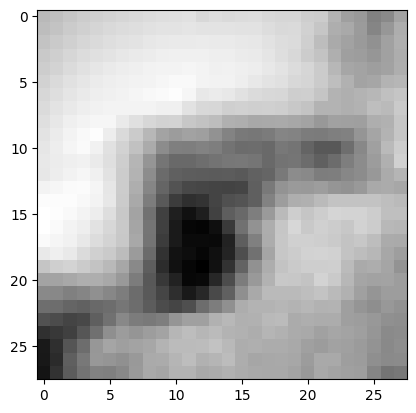

Label: i


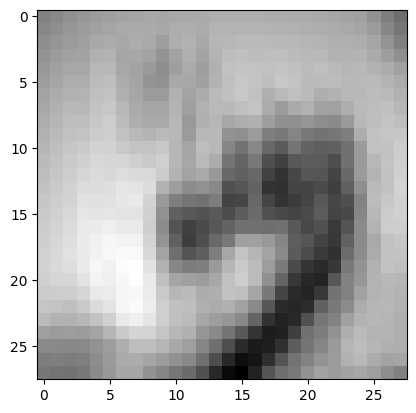

Label: k


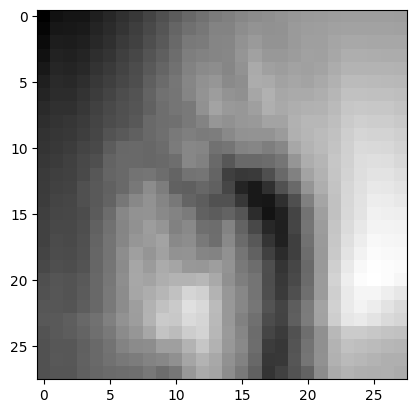

Label: l


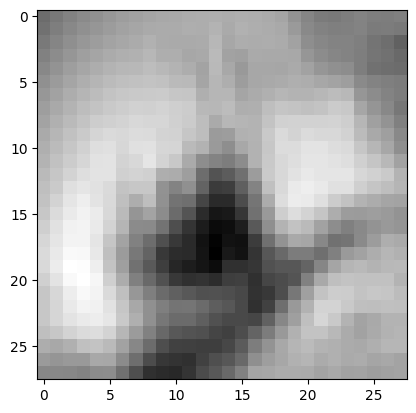

Label: m


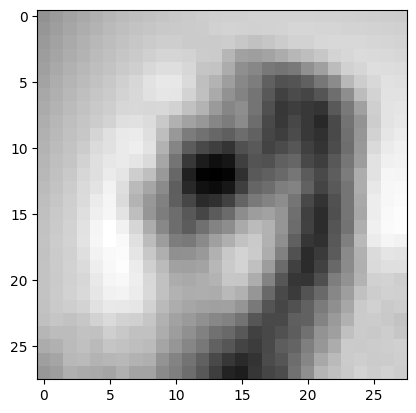

Label: n


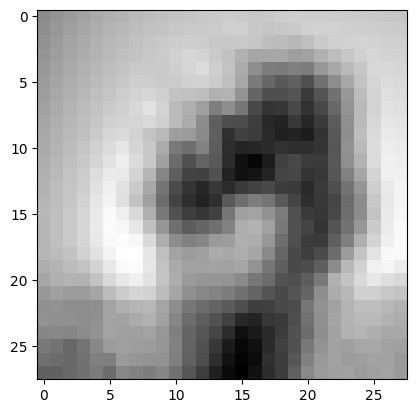

Label: o


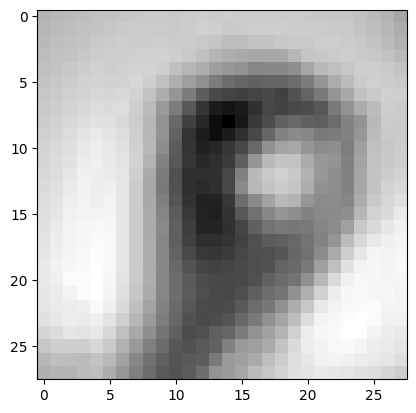

Label: p


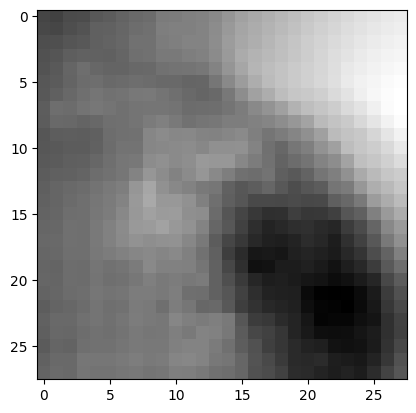

Label: q


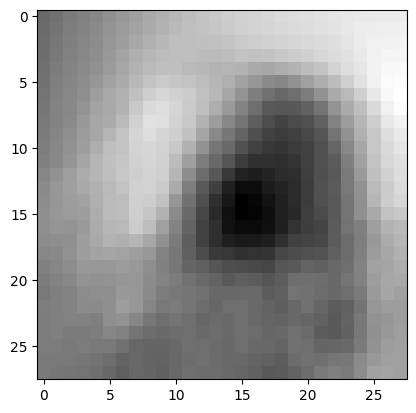

Label: r


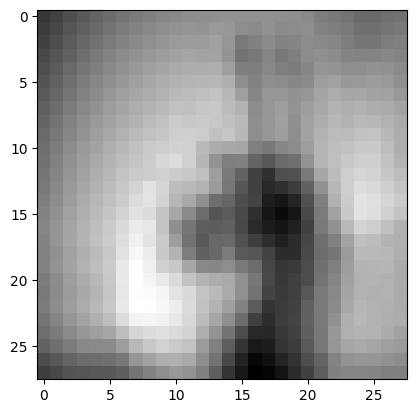

Label: s


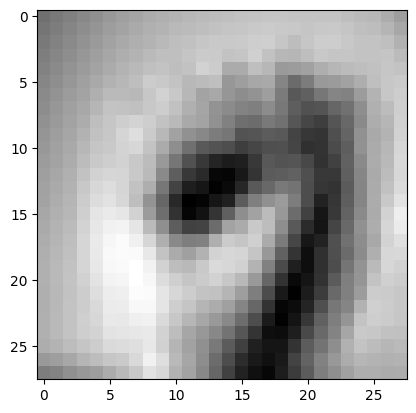

Label: t


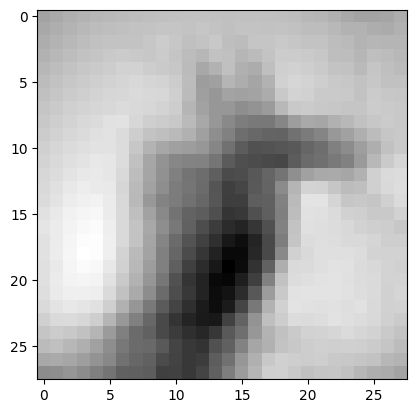

Label: u


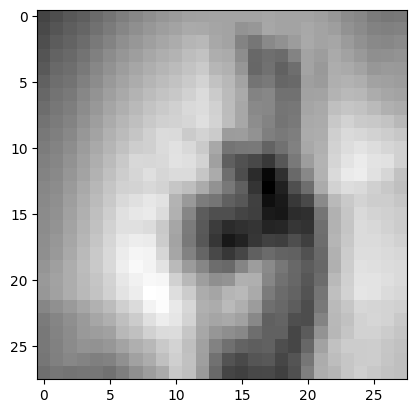

Label: v


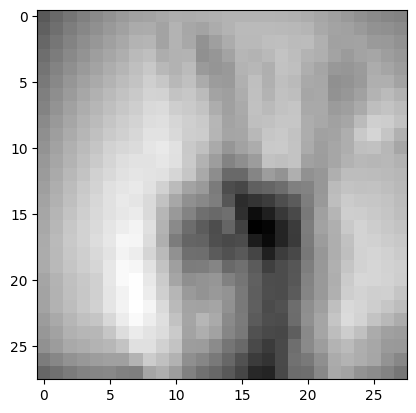

Label: w


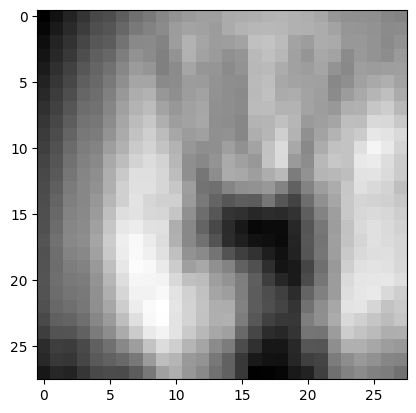

Label: x


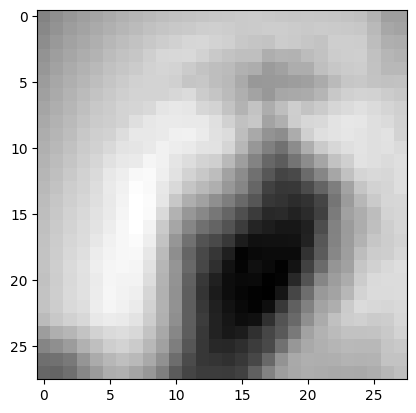

Label: y


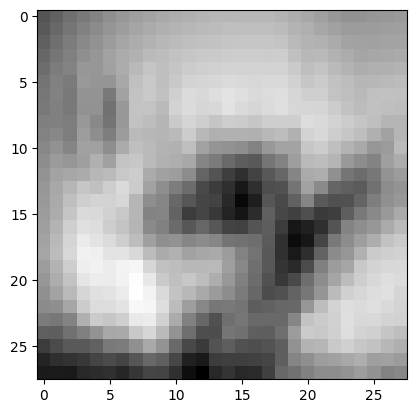

In [87]:
# 3 - C
plot_estimated_mean_vectors(mu_ml,labels)

In [88]:
# 4

classifier_accuracy = custom_QDA_accuracy(Y_train,labels[y_pred_array])
print(f"the accuracy of the classifier is {classifier_accuracy}%")

cm = confusion_matrix(Y_train, labels[y_pred_array])
print("Confusion Matrix:")
print(cm)


the accuracy of the classifier is 100.0%
Confusion Matrix:
[[1126    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0 1144    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 1196    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  957    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1204    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1090    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1013    0    0    0    0    0

In [89]:

cr = classification_report(Y_train, labels[y_pred_array])
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1126
           1       1.00      1.00      1.00      1010
           2       1.00      1.00      1.00      1144
           3       1.00      1.00      1.00      1196
           4       1.00      1.00      1.00       957
           5       1.00      1.00      1.00      1204
           6       1.00      1.00      1.00      1090
           7       1.00      1.00      1.00      1013
           8       1.00      1.00      1.00      1162
          10       1.00      1.00      1.00      1114
          11       1.00      1.00      1.00      1241
          12       1.00      1.00      1.00      1055
          13       1.00      1.00      1.00      1151
          14       1.00      1.00      1.00      1196
          15       1.00      1.00      1.00      1088
          16       1.00      1.00      1.00      1279
          17       1.00      1.00      1.00      1294
    

Question 9

In [90]:

QDA_API = QuadraticDiscriminantAnalysis(store_covariance=True)
QDA_API.fit(reshaped_X_train,Y_train)

pi_ml_sklearn = QDA_API.priors_
mu_ml_sklearn = QDA_API.means_
sigma_ml_sklearn = QDA_API.covariance_
print(f"shapes of Θ:\npi_ml: {np.array(pi_ml_sklearn).shape} \nmu_ml: {np.array(mu_ml_sklearn).shape} \nsigma_ml: {np.array(sigma_ml_sklearn).shape}")

shapes of Θ:
pi_ml: (24,) 
mu_ml: (24, 784) 
sigma_ml: (24, 784, 784)


In [91]:
from sklearn.metrics import mean_squared_error

#compare our result to the API result
def diff_between_custom_and_API(pi_ml,pi_ml_sklearn,mu_ml,mu_ml_sklearn,sigma_ml,sigma_ml_sklearn):
    mse_pi_ml = mean_squared_error(pi_ml, pi_ml_sklearn)  # prompt-3
    mse_mu_ml = mean_squared_error(mu_ml, mu_ml_sklearn) # prompt-3
    sigma_ml_numpy = np.array(sigma_ml)    
    sigma_ml_sklearn_numpy = np.array(sigma_ml_sklearn)
    diff_count = np.count_nonzero(~(sigma_ml_numpy == sigma_ml_sklearn_numpy)) # prompt-3
    print(f"Mean Squared Error for priors (pi_ml): {mse_pi_ml}")
    print(f"Mean Squared Error for means (mu_ml): {mse_mu_ml}")
    print(f"Mean Squared Error for covariance (sigma_ml) count_nonzero : {diff_count}") 
    # we can that there are many erros in sigma compare cause by extra clc that only the API does

diff_between_custom_and_API(pi_ml,pi_ml_sklearn,mu_ml,mu_ml_sklearn,sigma_ml,sigma_ml_sklearn)

Mean Squared Error for priors (pi_ml): 0.0
Mean Squared Error for means (mu_ml): 0.0
Mean Squared Error for covariance (sigma_ml) count_nonzero : 14751744


In [92]:
predictions_QDA_API = QDA_API.predict(reshaped_X_train)

accuracy_QDA_API = accuracy_score(Y_train, predictions_QDA_API)

print("Accuracy:", accuracy_QDA_API)

cm_QDA_API = confusion_matrix(Y_train, predictions_QDA_API)
print("Confusion Matrix:")
print(cm)

cr_QDA_API = classification_report(Y_train, predictions_QDA_API)
print("Classification Report:")
print(cr)

Accuracy: 1.0
Confusion Matrix:
[[1126    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0 1144    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 1196    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  957    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1204    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1090    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1013    0    0    0    0    0    0
     0    0    0    0

test data original shape: (28, 28, 5101)
The labels in this data: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
The labels in the data: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label: g


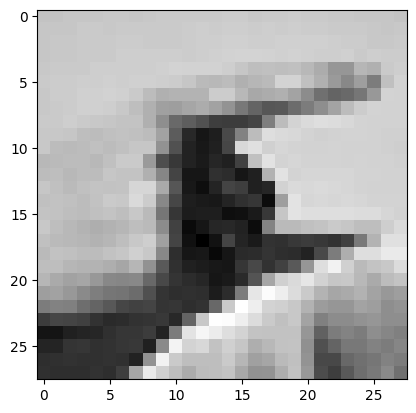

Label: f


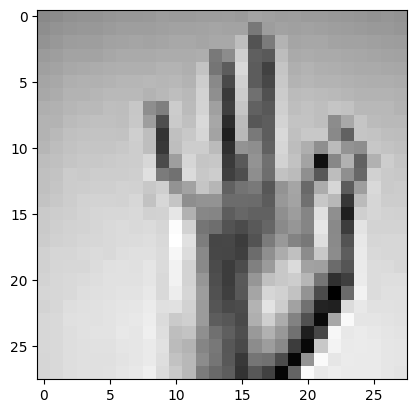

Label: k


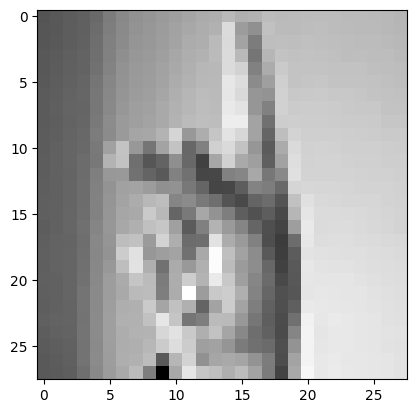

Label: a


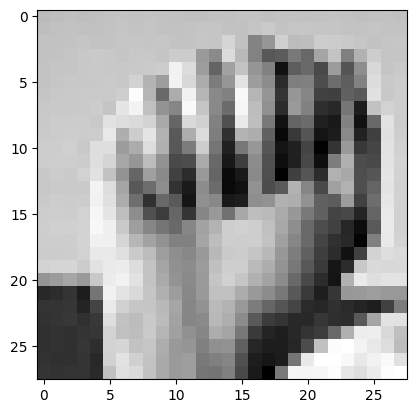

Label: d


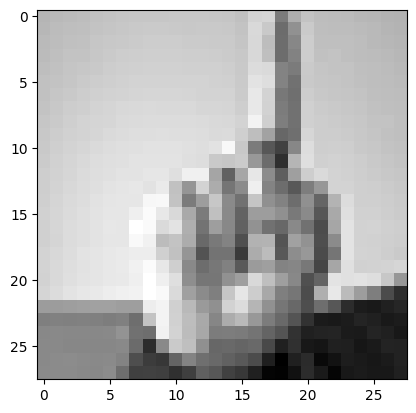

Label: o


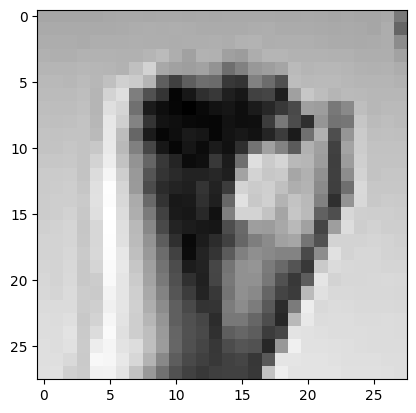

Label: h


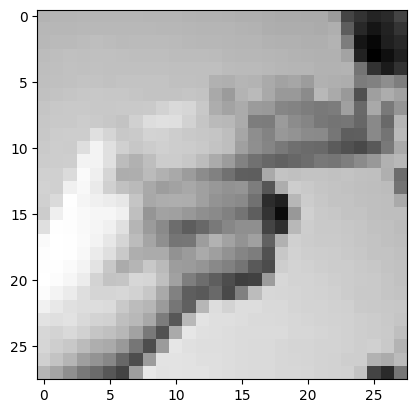

Label: i


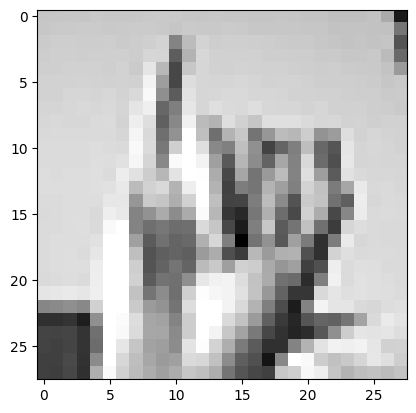

Label: e


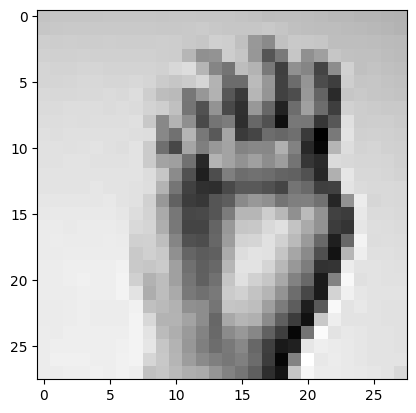

Label: w


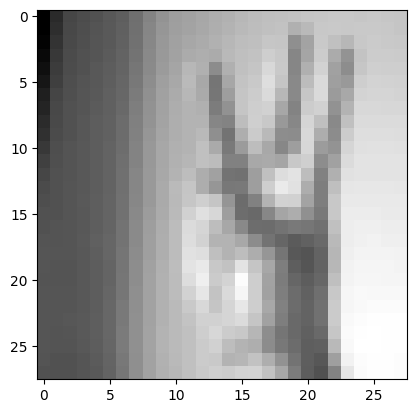

Label: c


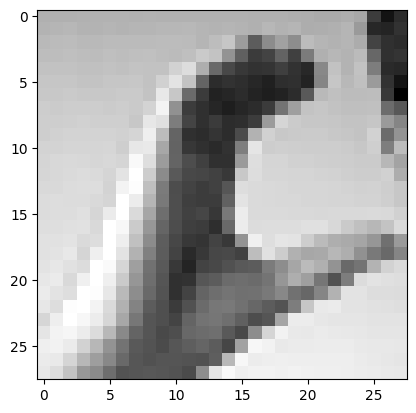

Label: t


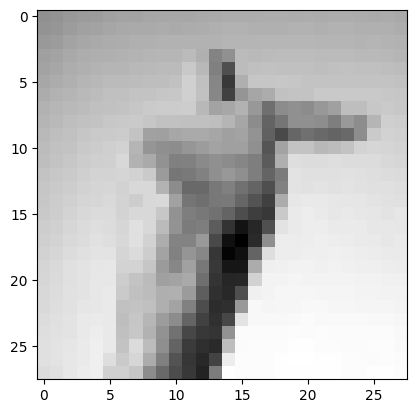

Label: v


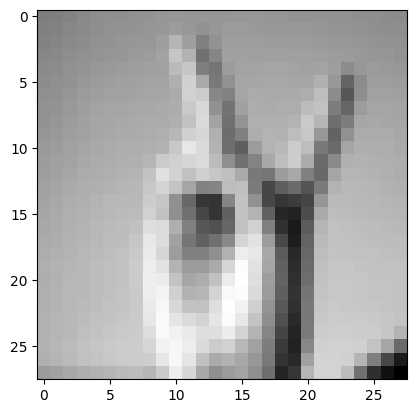

Label: s


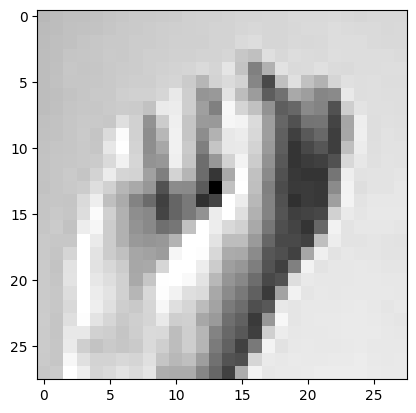

Label: r


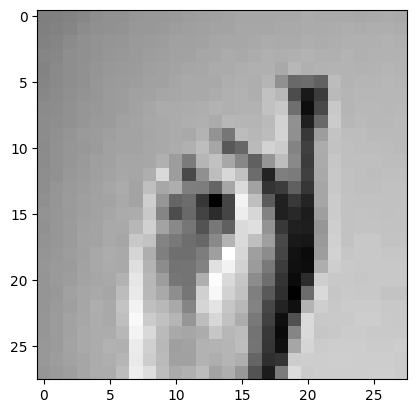

Label: n


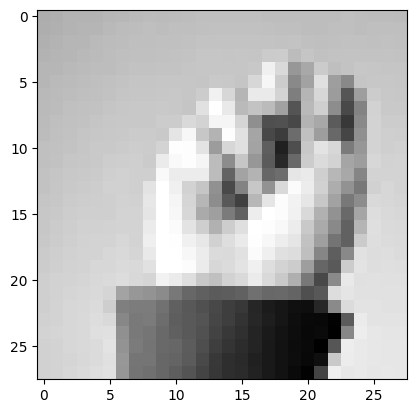

Label: u


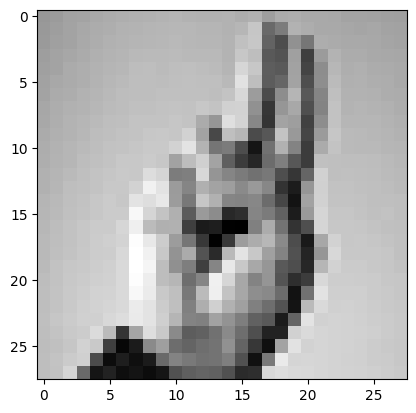

Label: q


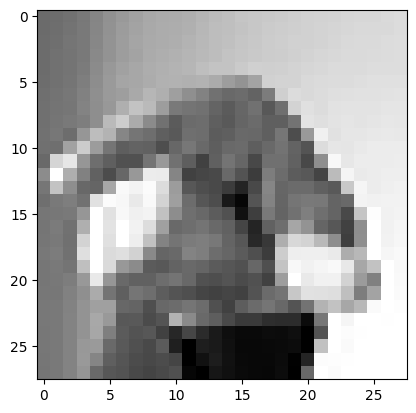

Label: l


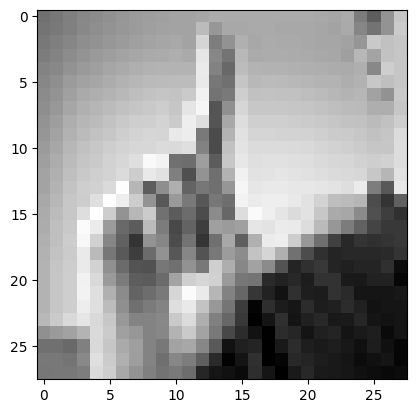

Label: p


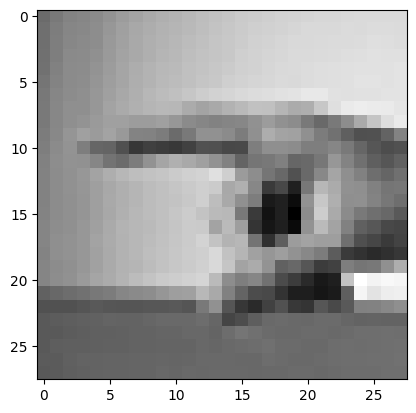

Label: x


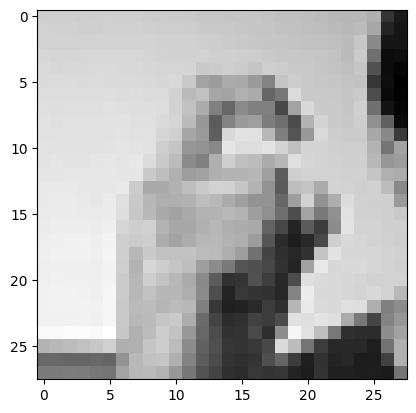

Label: m


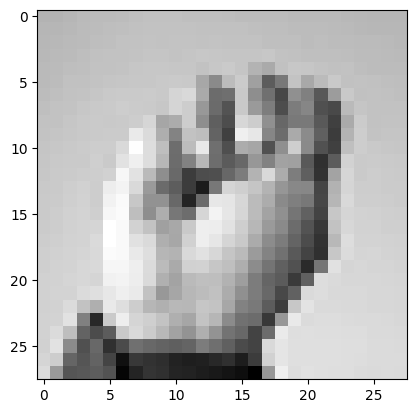

Label: b


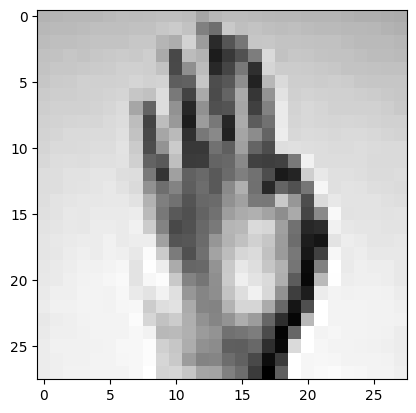

Label: y


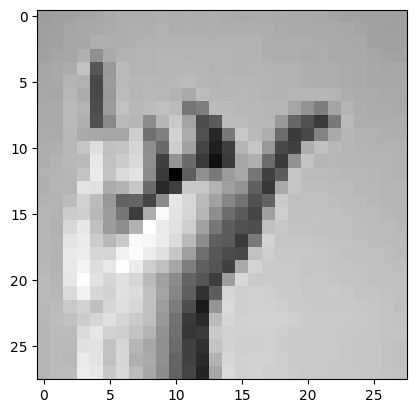

In [93]:
# Q - 5 - again Q 1 A

TestData = load_pkl("TestData.pkl")
X_test , Y_test = get_X_Y(TestData)
print(f"test data original shape: {X_test.shape}")

#  Q - 5 - again Q 1 B

X_test = np.moveaxis(X_test, -1 , 0) # prompt-1
X_test = to_numpy_float(X_test)
print_unique_labels(Y_test)
print_unique_images(X_test, Y_test)

Question 10

In [94]:
# Q - 5 - again Q 1 C
reshaped_X_test = np.array([image.reshape(784) for image in X_test])

x_examples_test = reshaped_X_test
y_examples_test = Y_test

sigma_ml_inv_array = []
sigma_ml_det_array = []
for i in range(len(labels)):                        # calclate the det and the inv for each label
    sigma_ml_numpy = np.array(sigma_ml[i])
    sigma_ml_inv = np.linalg.inv(sigma_ml_numpy)
    sigma_ml_det , matrix_tmp = np.linalg.eig(sigma_ml[i])
    sigma_ml_inv_array.append(sigma_ml_inv)
    sigma_ml_det_array.append(sigma_ml_det)

# use our classification functions we create before to find the prediction
y_pred_array_test = custom_QDA_classification(x_examples_test, labels , mu_ml , pi_ml , sigma_ml_det_array, sigma_ml_inv_array)

classifier_accuracy_test = custom_QDA_accuracy(y_examples_test, labels[y_pred_array_test])
print(f"the accuracy of the classifier is {classifier_accuracy_test}%")



the accuracy of the classifier is 92.43285630268575%


Label: a


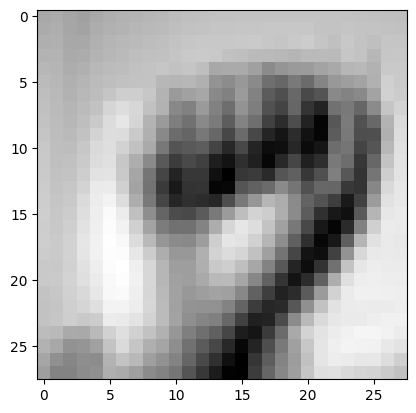

Label: b


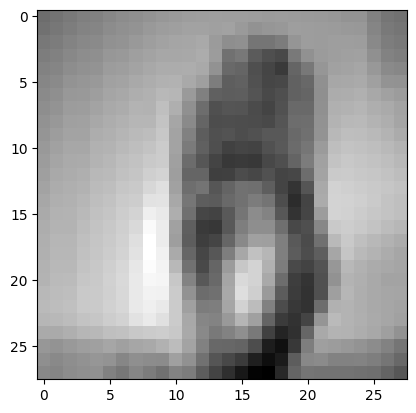

Label: c


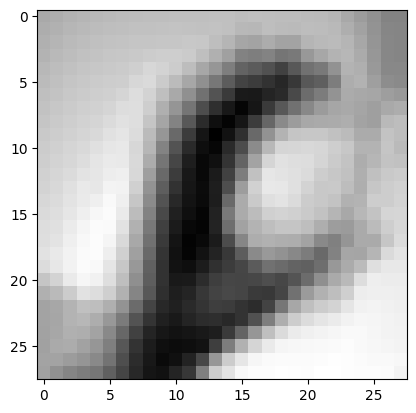

Label: d


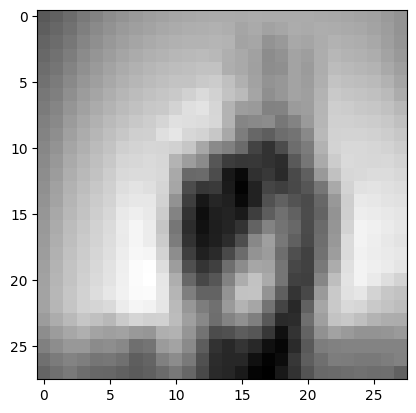

Label: e


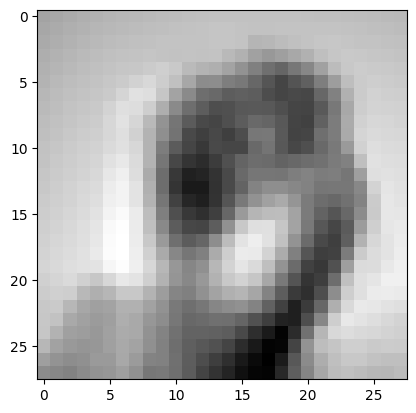

Label: f


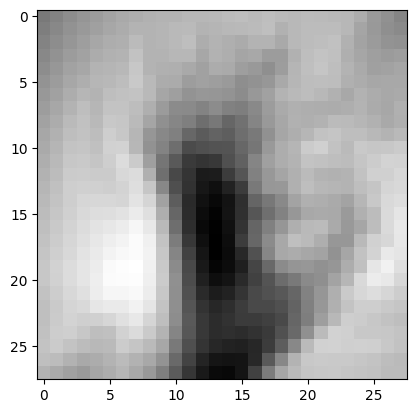

Label: g


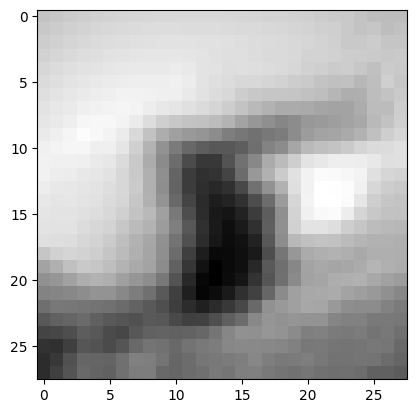

Label: h


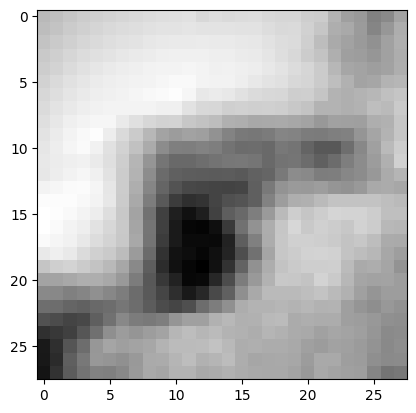

Label: i


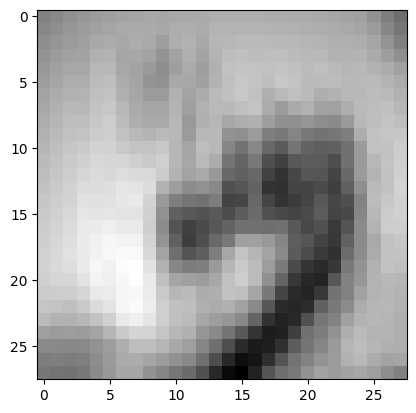

Label: k


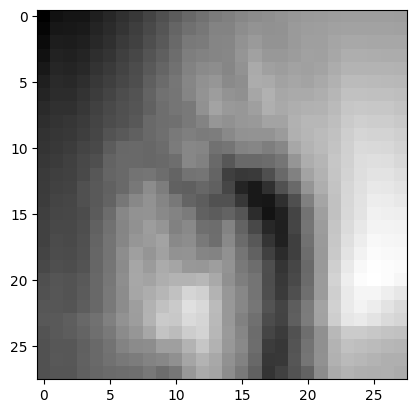

Label: l


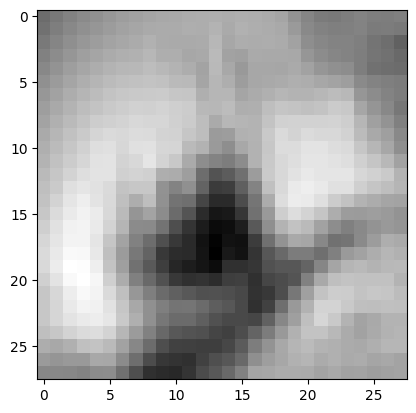

Label: m


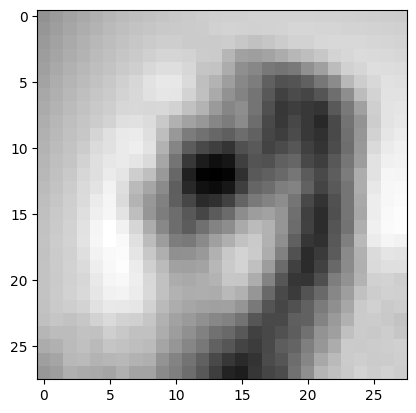

Label: n


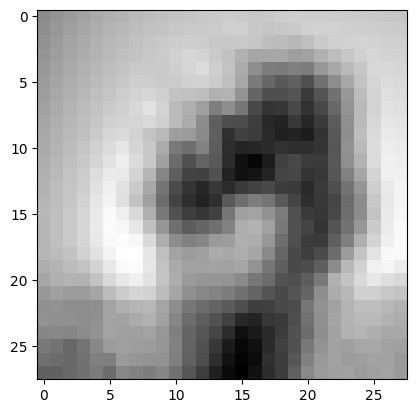

Label: o


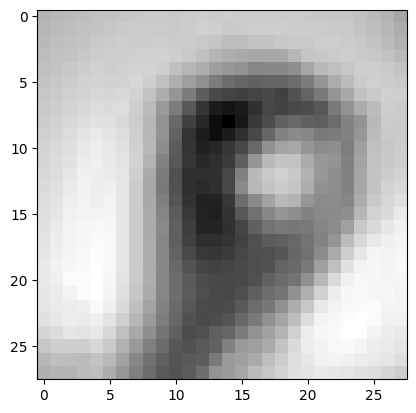

Label: p


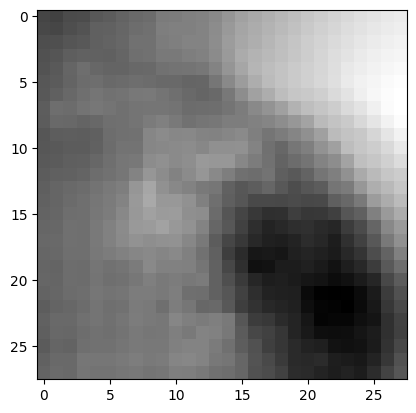

Label: q


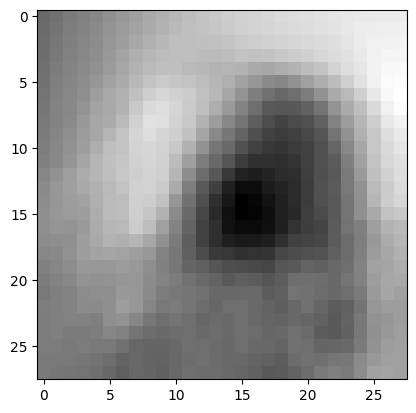

Label: r


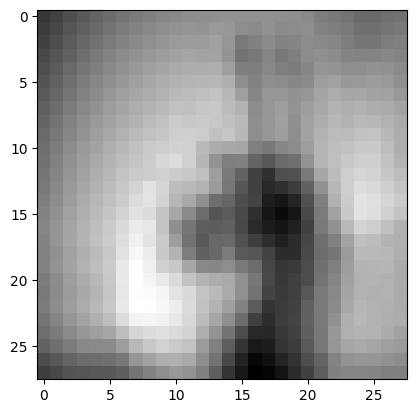

Label: s


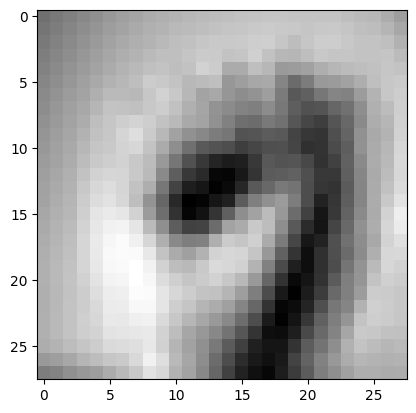

Label: t


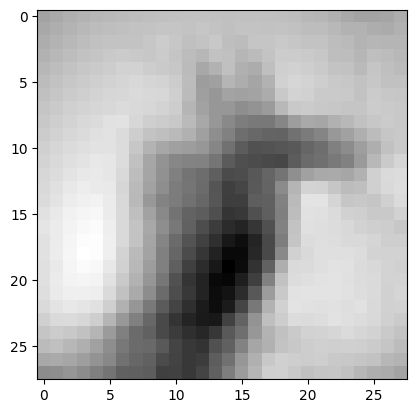

Label: u


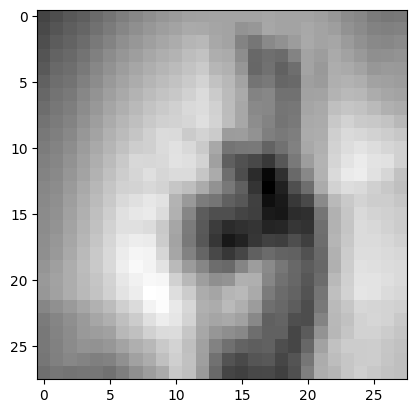

Label: v


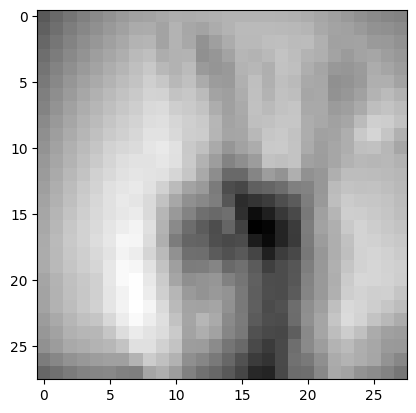

Label: w


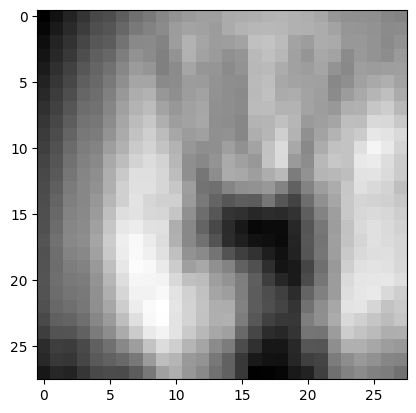

Label: x


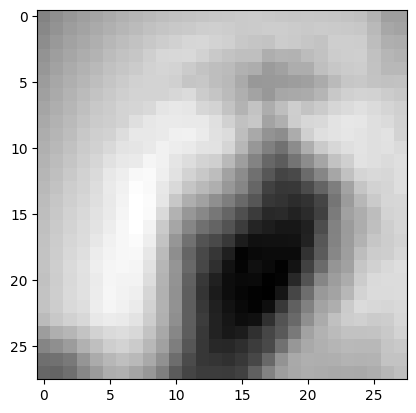

Label: y


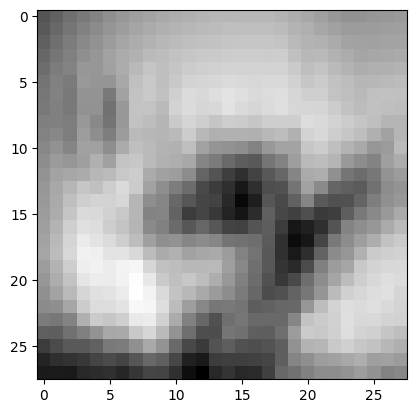

In [95]:
# 3 - C - again
plot_estimated_mean_vectors(mu_ml,labels)

In [96]:
cm = confusion_matrix(y_examples_test, labels[y_pred_array_test])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 270   0   4   0   0   0   0   0   3   0   0   0   0   0   5   3   0
    0   0   0   6   0   0]
 [  0   0 289   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 226   0   0   0   0   0   0   0   0   0   0   0   0   5   0
    0   0   0   0   0   0]
 [  0   0   0   0 191   0   0   0   0   0   0   0   8   0   0  11   0  24
    0   0   0   0   0   0]
 [  0   0   0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 246   0   0   0   0   0   0   0   0  18   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   7 168   0   0   0   0   0   0   0  26   0   0
    7   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 227   0   0   0   0   0   0   4   4   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 228   0   0   0   0   0   4  13   0

In [97]:

cr = classification_report(y_examples_test, labels[y_pred_array_test])
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.93      0.96       291
           2       1.00      0.99      0.99       293
           3       0.98      0.98      0.98       231
           4       1.00      0.82      0.90       234
           5       1.00      1.00      1.00       245
           6       0.97      0.93      0.95       264
           7       1.00      0.81      0.89       208
           8       1.00      0.97      0.98       235
          10       0.99      0.93      0.96       245
          11       1.00      0.97      0.99       193
          12       1.00      0.80      0.89       198
          13       0.88      0.94      0.91       227
          14       0.98      0.96      0.97       175
          15       1.00      0.56      0.72       115
          16       0.46      1.00      0.63       164
          17       0.75      1.00      0.86       140
    

In [98]:

predictions_QDA_API = QDA_API.predict(reshaped_X_test)

accuracy_QDA_API = accuracy_score(Y_test, predictions_QDA_API)

print("Accuracy:", accuracy_QDA_API)

cm_QDA_API = confusion_matrix(Y_test, predictions_QDA_API)
print("Confusion Matrix:")
print(cm)

cr_QDA_API = classification_report(Y_test, predictions_QDA_API)
print("Classification Report:")
print(cr)

Accuracy: 0.9243285630268575
Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 270   0   4   0   0   0   0   0   3   0   0   0   0   0   5   3   0
    0   0   0   6   0   0]
 [  0   0 289   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 226   0   0   0   0   0   0   0   0   0   0   0   0   5   0
    0   0   0   0   0   0]
 [  0   0   0   0 191   0   0   0   0   0   0   0   8   0   0  11   0  24
    0   0   0   0   0   0]
 [  0   0   0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 246   0   0   0   0   0   0   0   0  18   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   7 168   0   0   0   0   0   0   0  26   0   0
    7   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 227   0   0   0   0   0   0   4   4   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 228   

In [99]:
MessageData = load_pkl("MessageData.pkl")
X_Message = MessageData['X']
print(f"Message data original shape: {X_Message.shape}")


MessageData_images = np.moveaxis(X_Message, -1 , 0) # prompt-1
MessageData_images = to_numpy_float(MessageData_images)

indices_to_remove = []

for i in range(MessageData_images.shape[0]):        # prompt-4
    # Check if the matrix contains all zeros
    if np.all(MessageData_images[i] == 0):
        indices_to_remove.append(i)

# Remove matrices containing all zeros
new_matrix = np.delete(MessageData_images, indices_to_remove, axis=0) # prompt-4

print(f"Message after remove the spaces shape: {new_matrix.shape}")

reshaped_MessageData = np.array([image.reshape(784) for image in new_matrix])

sigma_ml_inv_array = []
sigma_ml_det_array = []
for i in range(len(labels)):                            # calclate the det and the inv for each label
    sigma_ml_numpy = np.array(sigma_ml[i])
    sigma_ml_inv = np.linalg.inv(sigma_ml_numpy)
    sigma_ml_det , matrix_tmp = np.linalg.eig(sigma_ml[i])
    sigma_ml_inv_array.append(sigma_ml_inv)
    sigma_ml_det_array.append(sigma_ml_det)


# use our classification functions we create before to find the prediction
y_pred_MessageData = custom_QDA_classification(reshaped_MessageData, labels , mu_ml , pi_ml , sigma_ml_det_array, sigma_ml_inv_array)
print(y_pred_MessageData)

k = 0
message_chars = []
for i in range(MessageData_images.shape[0]):
    if i in indices_to_remove:
        k += 1
        message_chars.append(" ")
    else:
        message_chars.append(chr(ord('a') + labels[y_pred_MessageData[i-k]])) # prompt-2

combined = ''.join(message_chars)
print(f"****\n****\nThe message:\n{combined}")



Message data original shape: (28, 28, 94)
Message after remove the spaces shape: (78, 28, 28)
[0, 6, 16, 4, 0, 18, 21, 0, 23, 18, 13, 10, 4, 0, 16, 12, 7, 13, 21, 0, 11, 0, 2, 7, 8, 12, 4, 10, 4, 0, 16, 12, 8, 12, 6, 0, 10, 6, 13, 16, 8, 18, 7, 11, 21, 13, 16, 9, 17, 8, 17, 1, 23, 8, 11, 14, 10, 4, 11, 4, 12, 18, 8, 12, 6, 8, 18, 5, 16, 13, 11, 17, 2, 16, 0, 18, 2, 7]
****
****
The message:
a great way to learn how a machine learning algorithm works is by implementing it from scratch
